In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc
import configs

from data.ValidationDataset import NoisyDataset

# Load PCA

In [212]:
# Arg
conv_idx = 5
t = 0

In [213]:
netname = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
activations_dir = f'{engram_dir}3_activations/{netname}/'
pca_activations_dir = f'{engram_dir}4_activations_pca/{netname}/'

In [214]:
pca_filename = f'FullPCAmodel_conv{conv_idx}_t{t}'
with open(f'{pca_activations_dir}{pca_filename}.p', 'rb') as f:
    pca = pickle.load(f)
gc.collect()

6099

# Plot components

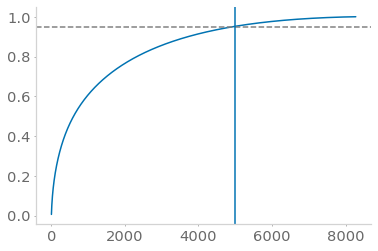

In [215]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.95, color='gray', linestyle='--')
plt.axvline(5000)
plt.show()

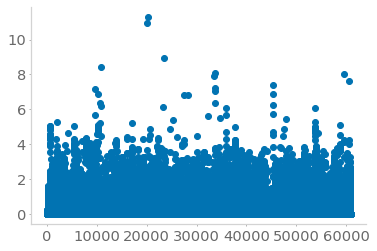

In [206]:
size_range = np.arange(pca.mean_.size)
plt.figure()
plt.scatter(size_range, pca.mean_)
plt.show()

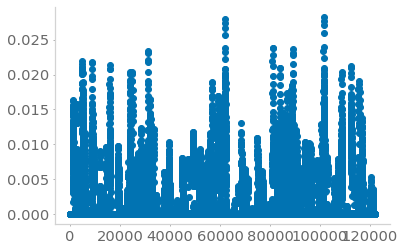

In [165]:
plt.figure()
plt.scatter(size_range, pca.components_[0,:])
plt.show()

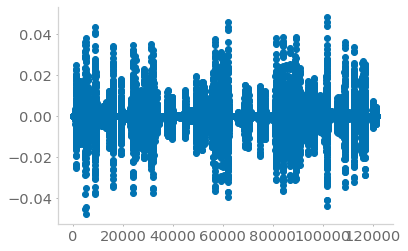

In [166]:
plt.figure()
plt.scatter(size_range, pca.components_[1,:])
plt.show()

# Fit transform

In [167]:
bg_types = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snr_types = [-9.0, -6.0, -3.0, 0.0, 3.0]
def get_data(conv_idx, t, sample_size=None):
    X = []
    bgs = []
    snrs = []
    dset_idxs = []
    n_total_data = 0
    n_sampled_data = 0
    for bg in bg_types:
        for snr in snr_types:
            activ_dir = f'{activations_dir}{bg}_snr{int(snr)}/'
            for results_file in os.listdir(activ_dir):
                results_filepath = f'{activ_dir}{results_file}'
                results = h5py.File(results_filepath, 'r')
            if conv_idx > 3:
                activ = np.array(results[f'conv{conv_idx}_W_{t}_activations'])
            else:
                activ = np.array(results[f'conv{conv_idx}_{t}_activations'])
            n_data = activ.shape[0]
            n_total_data += n_data
            if sample_size != None:
                sample_idxs = np.random.choice(n_data, size=sample_size)
                activ = activ[sample_idxs]
                n_sampled_data += sample_size
                _dset_idxs = list(sample_idxs)
            else:
                n_sampled_data += n_data
                _dset_idxs = list(range(n_data))
            new_n_data = activ.shape[0]
            activ = list(activ.reshape((new_n_data, -1)))
            X.extend(activ)
            snrs.extend([snr]*new_n_data)
            bgs.extend([bg]*new_n_data)
            dset_idxs.extend(_dset_idxs)
            
            del results
            del activ
            gc.collect()

    idxs = np.arange(len(X))
    np.random.shuffle(idxs)

    X = np.array(X)[idxs]
    bgs = np.array(bgs)[idxs]
    snrs = np.array(snrs)[idxs]
    dset_idxs = np.array(dset_idxs)[idxs]
    
    print(f'Sampled {n_sampled_data}/{n_total_data} data')
    print(f'with {X.shape[1]} features')
    
    return X, bgs, snrs, dset_idxs

In [168]:
X, bgs, snrs, dset_idxs = get_data(conv_idx, t)
X_pca = pca.transform(X)
del X
gc.collect()

Sampled 8279/8279 data
with 121856 features


0

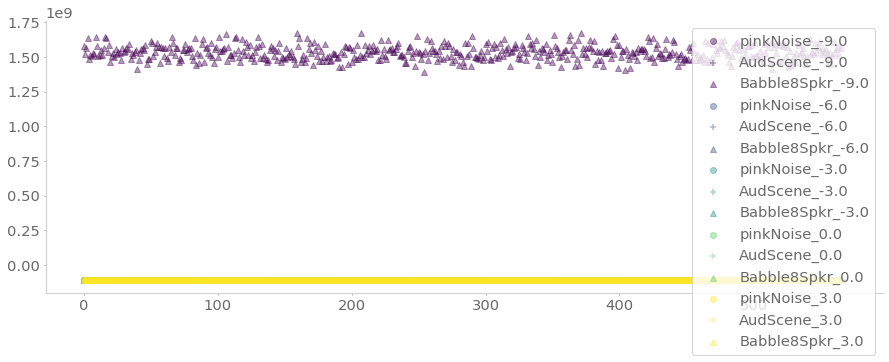

In [169]:
plt.figure(figsize=(15,5))
viridis = cm.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, len(snr_types)))
markers = ['o', '+', '^']
for snr_idx, snr in enumerate(snr_types):
    for bg_idx, bg in enumerate(bg_types):
        select = np.logical_and(snrs==snr, bgs==bg)
        plt.scatter(
            np.arange(np.sum(select)), X_pca[select,0],
            color=colors[snr_idx], marker=markers[bg_idx],
            label=f'{bg}_{snr}', alpha=0.4
            )
plt.legend()
plt.show()